## Solving Cliff-Walking Environment with Monte Carlo Control

Kenechi Franklin Dukor

Special thanks to Facebook-Pytorch and Udacity

#### Lets import the needed packages

In [12]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Lets create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment provided by `openai gym`

In [13]:
env = gym.make('CliffWalking-v0')

In [14]:
print(env.observation_space)
print(env.action_space)

Discrete(48)
Discrete(4)


The agent has 48 observation space (states) and 4 possible action

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through to `46`.

The agent gets a reward of `-100`, if hits a cliff, and `-1` for every other state. The agent must reach the termainal state in the least possible time while the rewards are still maximised.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

#### Lets test the environment and see how it behaves

In [15]:
episode = []
state = env.reset()

for movement in range(10):
    action = env.action_space.sample()

    next_state, reward, done, info = env.step(action)

    episode.append((state, action, reward))
    print("State: ", state, "\tAction: ", action, "\tReward: ", reward, "\tNext state: ", next_state)
    state = next_state

#     if done:
#         break

State:  36 	Action:  2 	Reward:  -1 	Next state:  36
State:  36 	Action:  1 	Reward:  -100 	Next state:  36
State:  36 	Action:  3 	Reward:  -1 	Next state:  36
State:  36 	Action:  1 	Reward:  -100 	Next state:  36
State:  36 	Action:  1 	Reward:  -100 	Next state:  36
State:  36 	Action:  3 	Reward:  -1 	Next state:  36
State:  36 	Action:  0 	Reward:  -1 	Next state:  24
State:  24 	Action:  0 	Reward:  -1 	Next state:  12
State:  12 	Action:  3 	Reward:  -1 	Next state:  12
State:  12 	Action:  0 	Reward:  -1 	Next state:  0


#### Visualize the Optimal Policy
We will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

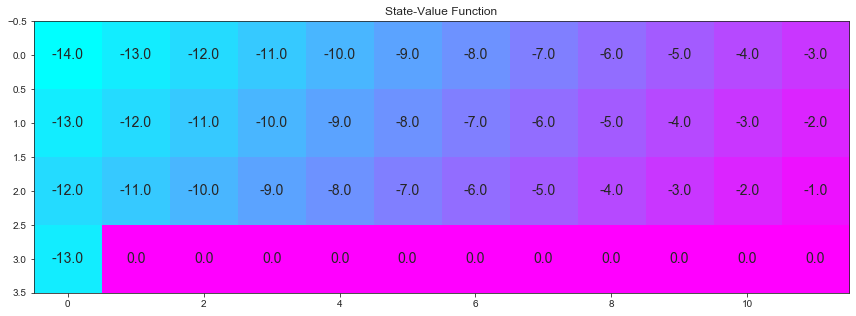

In [16]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Monte Carlo Control

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.


In [46]:
def MC_Control(env, num_episodes, alpha, gamma=1.0, eps_start=1, esp_decay=0.5, esp_limit=0.05):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    nA = env.nA
    
    epsilon = eps_start
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = max(epsilon * esp_decay, esp_limit)
        episode = generate_episode_using_epsilon_greedy(env, epsilon, Q, nA)
        
        Q = update_Q(episode, gamma, alpha, Q)
        
        policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [51]:
def generate_episode_using_epsilon_greedy(CW_env, epsilon, Q, nA):
    '''This will return an episode based on the epsilon-greedy implementation.
       It is a modification of "generate_episode_from_limit_stochastic" function created earlier'''
    episode = []
    state = CW_env.reset()
    counter = 0
    divisor = 1
    # Since it can take a long time for and episode to complete in this environment. lets restict it to number of actions
    for t_step in range(200):
        counter += 1
        if counter % 5 == 0:
            divisor = counter
        if state in Q:
            action = np.random.choice(np.arange(nA), get_eps_prob(divisor, nA, state, Q))
        else:
            action = CW_env.action_space.sample()

        next_state, reward, done, info = CW_env.step(action)
        
        if not done:

            episode.append((state, action, reward))
            state = next_state

        if done:
            break
    return episode

def get_eps_prob(i_episode, nA, state, Q, eps=None):
    if eps is not None:
        epsilon = eps
    else:
        epsilon = 1 / i_episode
        
    prob = np.ones(nA) * (epsilon / nA)
    
    # Get action from state
    prev_action = Q[state]
    
    # Get the position of the best action in the previous episode
    best_action_index = np.argmax(prev_action)
    
    prob[best_action_index] = (1 - epsilon) + (epsilon / nA)

def update_Q(episode, gamma, alpha, Q):
    """Update the action-value function estimate with the most recent episode"""
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, s in enumerate(states):
        G = sum(rewards[i:]*discounts[:-(1+i)])
        Q[s][actions[i]] = Q[s][actions[i]] + (alpha * (G - Q[s][actions[i]]))
    
    return Q

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = MC_Control(env, 8000, 0.01)

Episode 7708/8000

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  0  3  1  3  2  0 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  1  0 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  3  0 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


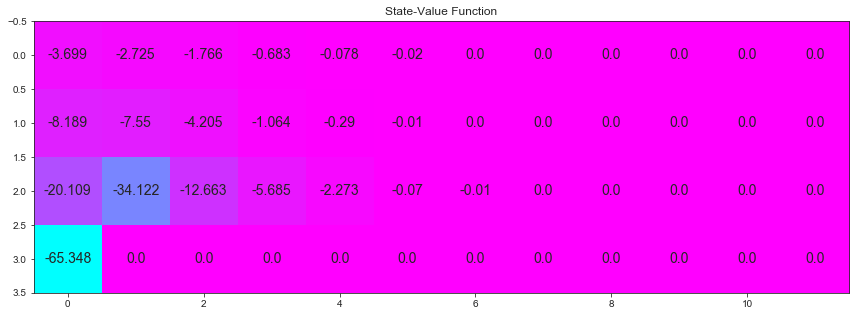

In [42]:
# print the estimated optimal policy
policy_check = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_check)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_check)

# plot the estimated optimal state-value function
V = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])
plot_values(V)

### Test

Lets test the policy

In [37]:
def Test(env, policy):
    state = env.reset()
    while True:
        if state in policy:
            action = policy[state]
        else:
            action = env.action_space.sample()
            
        next_state, reward, done, info = env.step(action)

        episode.append((state, action, reward))
        print("State: ", state, "\tAction: ", action, "\tReward: ", reward, "\tNext state: ", next_state)
        state = next_state
        if done:
            break

In [38]:
Test(env, policy)

State:  36 	Action:  0 	Reward:  -1 	Next state:  24
State:  24 	Action:  0 	Reward:  -1 	Next state:  12
State:  12 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Rew

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward:  -1 	Next state:  0
State:  0 	Action:  0 	Reward: 

KeyboardInterrupt: 

Notice that the Monte Carlo control did not perform well on this environment